<a href="https://colab.research.google.com/github/sugimotoh/seminar2018/blob/master/BayesABcross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy.random import *
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm

# generating data
def gen_sample(p, size):
    """
    Sample generating funcion
    """
    sample = binomial(n=1, p=p, size=size)
    commited = sum(sample)
    num = len(sample)
    rate = commited/num
    print("""
    num_outcome：{}
    sample_size：{}
    ratio_outcome：{}
    """.format(commited, num, rate))
    return sample

In [3]:
control_p, treated_p = 7/35, 16/36
print('control')
controlled = gen_sample(control_p, 35)
print('treated')
treated = gen_sample(treated_p, 36)

control

    num_outcome：7
    sample_size：35
    ratio_outcome：0.2
    
treated

    num_outcome：12
    sample_size：36
    ratio_outcome：0.3333333333333333
    


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta_c]
>Metropolis: [theta_t]
Sampling 2 chains: 100%|██████████| 61000/61000 [00:22<00:00, 2740.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82487ebe48>,
      dtype=object)

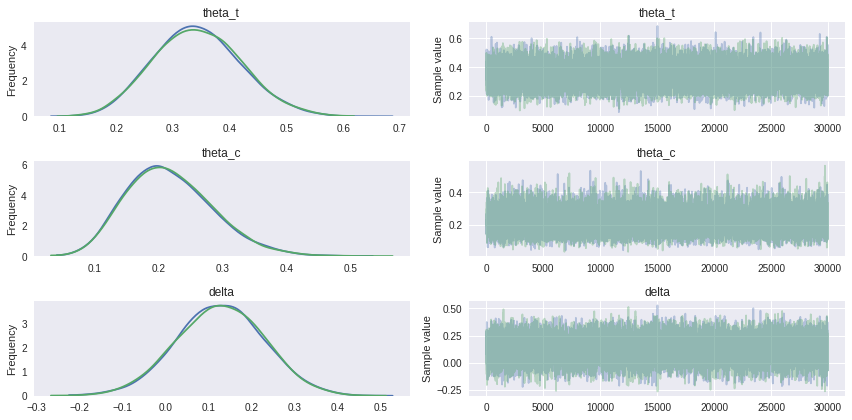

In [4]:
with pm.Model() as model:
# set prior distribution to treated and control
    theta_t = pm.Uniform("theta_t", 0, 1)
    theta_c = pm.Uniform("theta_c", 0, 1)
    
# for the purpose of check the distribution of theta, as difference between treated and control
    delta = pm.Deterministic("delta", theta_t - theta_c)
    
# set the distribution of observations as Bernoulli
    obs_t = pm.Bernoulli("obs_t", theta_t, observed=treated)
    obs_c = pm.Bernoulli("obs_c", theta_c, observed=controlled)

# MCMC metropolis heisting
    step = pm.Metropolis()
    trace = pm.sample(30000, step=step, njobs=2)
    burned_trace=trace[1000:]

# MCMC traceplot
pm.traceplot(trace)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


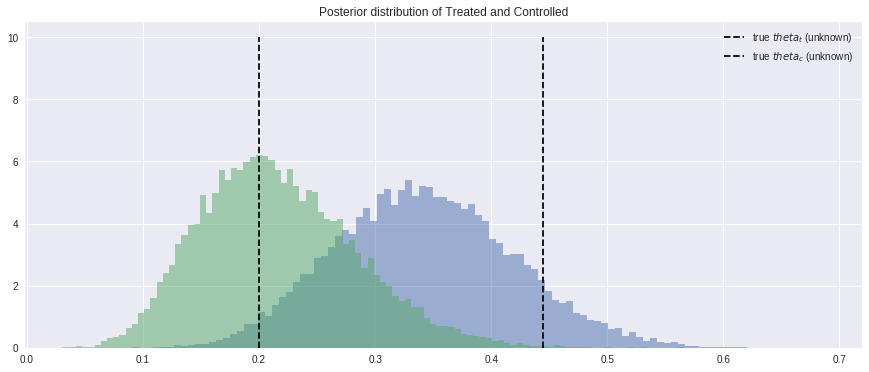

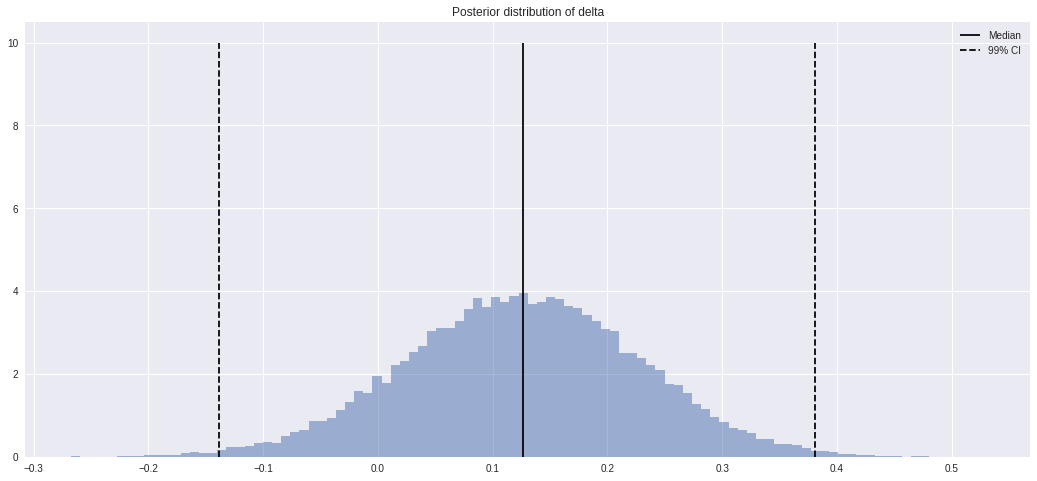

In [7]:
# result of MCMC as variable
theta_t_samples = burned_trace["theta_t"]
theta_c_samples = burned_trace["theta_c"]
delta_samples = burned_trace["delta"]

# plot the posterior distribution of theta of treated and control
plt.figure(figsize=(15, 6))
plt.title("Posterior distribution of Treated and Controlled")
plt.vlines(treated_p, 0, 10, linestyle="--", label="true $theta_t$ (unknown)")
plt.vlines(control_p, 0, 10, linestyle="--", label="true $theta_c$ (unknown)")
plt.hist(theta_t_samples, bins=100, histtype="stepfilled", normed=True, alpha=0.5)
plt.hist(theta_c_samples, bins=100, histtype="stepfilled", normed=True, alpha=0.5)
plt.legend()
plt.show()

# plot the posterior distribution of difference between treated and control
CI = pm.stats.hpd(delta_samples, alpha=0.01)
plt.figure(figsize=(18, 8))
plt.title("Posterior distribution of delta")
plt.vlines(np.median(delta_samples), 0, 10, linestyle="-", label="Median")
plt.vlines(CI[0], 0, 10, linestyle="--", label="99% CI")
plt.vlines(CI[1], 0, 10, linestyle="--")
plt.hist(delta_samples, bins=100, histtype="stepfilled", normed=True, alpha=0.5)
plt.legend()
plt.show()

In [8]:
print((delta_samples>0).sum()/len(delta_samples))

0.8918448275862069
